# IST 691: Deep Learning in Practice

**Homework 3**

Name: Ximeng Deng

SUID: 412575955

*Save this notebook into your Google Drive. The notebook has appropriate comments at the top of code cells to indicate whether you need to modify them or not. Answer your questions directly in the notebook. Remember to use the GPU as your runtime. Once finished, run ensure all code blocks are run, download the notebook and submit through Blackboard.*

### Setup

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import string
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# to build nearest neighbor model
from sklearn.neighbors import NearestNeighbors

In this homework, we will perform **sarcasm detection** with [Onion](https://www.theonion.com/) vs [HuffPost](https://www.huffpost.com/) headlines, using LSTM. We will first load the data and generate the training and testing input and labels.

In [ ]:
! wget -nc -q https://github.com/mrech/NLP_TensorFlow/blob/master/0_Sentiment_in_Text/Sarcasm_Headlines_Dataset_v2.json?raw=true

In [ ]:
# read the downloaded dataset
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json?raw=true', lines = True)

In [ ]:
# get information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
# take a peek at the key data
df[['headline', 'is_sarcastic']].head(5).values

array([['thirtysomething scientists unveil doomsday clock of hair loss',
        1],
       ['dem rep. totally nails why congress is falling short on gender, racial equality',
        0],
       ['eat your veggies: 9 deliciously different recipes', 0],
       ['inclement weather prevents liar from getting to work', 1],
       ["mother comes pretty close to using word 'streaming' correctly",
        1]], dtype=object)

In [ ]:
# the training input sequence will be in variable seq_padd_train and the label in train_y
# The testing input sequence will be in variable seq_padd_test and the label in test_y
headlines = df['headline'].values.tolist()
sarcastic = df['is_sarcastic'].values.tolist()

In [ ]:
training_size = 20000
test_size = 6709

train_x = headlines[:training_size]
test_x = headlines[training_size:]
train_y = np.array(sarcastic[:training_size])
test_y = np.array(sarcastic[training_size:])

# sequence of words input
max_len = 16

tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(train_x)

word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = len(word_index)
sequence_train = tokenizer.texts_to_sequences(train_x)
seq_padd_train = pad_sequences(sequence_train,
                               padding = 'post',
                               truncating = 'post',
                               maxlen = max_len)


sequence_test = tokenizer.texts_to_sequences(test_x)
seq_padd_test = pad_sequences(sequence_test, padding = 'post',
                              truncating = 'post',
                              maxlen = max_len)

In [ ]:
vocab_size

25898

### Q1 Calculating the Trainable Parameters of an LSTM

Below is the summary of an LSTM neural network with embeddings and three layers. Explain in detail, after this cell, the "why" of the number of parameters of each of the layers displayed by `model1.summary()`. Cite any sources you used to answer this question.

`model1.summary()`
```
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000100   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 96)          86400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                41216     
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
=================================================================
Total params: 2,245,029
Trainable params: 2,245,029
Non-trainable params: 0
_________________________________________________________________
```

**Why do we have the number of parameters after each of the layers?**

*answer here*

**Embedding**

Embedding Dimension: 100

Parameters = Vocab Size × Embedding Dimension

We have sequences of varying lengths and we set the max len to 16. Sequences that are longer are truncated at the end. We also need to pad the shorter sequences with zeros to make them all the same length for batch processing.
We use a the mask_zero parameter in the Embedding layer to skip over these portions of the data.


**First LSTM Layer**

Input size from embedding: 100

Number of units: 128

Parameters: 4 x ((input dim + units) x units + units)
= 4 x 128 x (100 + 128 + 1)
= 117,248

**Second LSTM layer**

Input size from previous LSTM: 128

Number of units: 96

Parameters: 4 × ((128 + 96) x 96 + 96) = 86,400

**Third LSTM Layer**

Input size from previous LSTM: 96

Number of units: 64

Parameters: 4 x ((96 + 64) x 64 + 64) = 41,216

**Dense Layer**

Input size: 64

Number of units: 1

Parameters: 64 x 1 + 1 = 65


**Sources：**
MURAT KARAKAYA. “LSTM: Understanding the Number of Parameters.”
https://www.kaggle.com/code/kmkarakaya/lstm-understanding-the-number-of-parameters

### Q2: LSTM for Detecting Sarcasm

Modify the code below to create an embedding layer of dimension 50. The vocabulary size is in variable `vocab_size`, and remember to add one in the embedding for the "out of vocabulary" input. Define an LSTM with two layers, one with 64 memory size and the second with 32 memory size. Remember to use the suffix `2` for each of the variables you define (e.g., `x2`)

In [ ]:
# an integer input for vocab indices
inputs2 = tf.keras.Input(shape = (None,), dtype = 'int32')

# define the layers below Embedding -> LSTM 1 -> LSTM 2
x2 = layers.Embedding(input_dim = vocab_size + 1, output_dim = 50)(inputs2)

x2 = layers.LSTM(64, return_sequences = True)(x2)
x2 = layers.LSTM(32)(x2)

# we project onto a single unit output layer, and squash it with a sigmoid
predictions2 = layers.Dense(1, activation = 'sigmoid', name = 'predictions')(x2)

model2 = tf.keras.Model(inputs2, predictions2, name = 'lstm_simple')

# compile the model with binary crossentropy loss and an adam optimizer
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
epochs = 10
# fit the model using the train and test datasets
model2.fit(seq_padd_train, train_y,
           validation_split = 0.1,
           epochs = epochs,
           verbose = 2,
           batch_size = 64)

Epoch 1/10
282/282 - 24s - loss: 0.4169 - accuracy: 0.7968 - val_loss: 0.3299 - val_accuracy: 0.8555 - 24s/epoch - 85ms/step
Epoch 2/10
282/282 - 4s - loss: 0.1739 - accuracy: 0.9337 - val_loss: 0.3708 - val_accuracy: 0.8450 - 4s/epoch - 13ms/step
Epoch 3/10
282/282 - 3s - loss: 0.0782 - accuracy: 0.9743 - val_loss: 0.5454 - val_accuracy: 0.8440 - 3s/epoch - 9ms/step
Epoch 4/10
282/282 - 3s - loss: 0.0471 - accuracy: 0.9849 - val_loss: 0.6453 - val_accuracy: 0.8390 - 3s/epoch - 11ms/step
Epoch 5/10
282/282 - 4s - loss: 0.0323 - accuracy: 0.9897 - val_loss: 0.7658 - val_accuracy: 0.8255 - 4s/epoch - 12ms/step
Epoch 6/10
282/282 - 2s - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.7282 - val_accuracy: 0.8170 - 2s/epoch - 7ms/step
Epoch 7/10
282/282 - 2s - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.6485 - val_accuracy: 0.8285 - 2s/epoch - 7ms/step
Epoch 8/10
282/282 - 2s - loss: 0.0088 - accuracy: 0.9980 - val_loss: 0.8225 - val_accuracy: 0.8260 - 2s/epoch - 8ms/step
Epoch 9/10
282/282

In [ ]:
# estimate the test performance
model2.evaluate(seq_padd_test, test_y)

270/270 [==============================] - 1s 5ms/step - loss: 0.9589 - accuracy: 0.8293


[0.9589332938194275, 0.829330563545227]

### Q3: GloVe Word Embeddings

Use the code below to download the GloVe embeddings and create the matrix `embedding_matrix` corresponding to the vocabulary above. Define a layer `embedding_layer_glove` which will be use by the LSTM below. Evaluate the performance and compare to model above.

In [ ]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-11-11 03:48:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-11 03:48:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-11 03:48:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import os
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = vocab_size + 2
embedding_dim3 = 100
hits = 0
misses = 0

# prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim3))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # this includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 21242 words (4656 misses)


Create the embedding layer below:

In [ ]:
# create the embedding layer using the embedding_matrix from above
embedding_layer_glove = layers.Embedding(
    num_tokens,
    embedding_dim3,
    input_length = max_len,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False,
)

In [ ]:
# an integer input for vocab indices
inputs3 = tf.keras.Input(shape = (None,), dtype = 'int32')

# next, we add a layer to map those vocab indices into a space of dimensionality
x3 = embedding_layer_glove(inputs3)

x3 = layers.LSTM(32)(x3)

# we project onto a single unit output layer, and squash it with a sigmoid
predictions3 = layers.Dense(1, activation = 'sigmoid', name = 'predictions')(x3)

model3 = tf.keras.Model(inputs3, predictions3)

# compile the model with binary crossentropy loss and an adam optimizer.
model3.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
# fit the model using the train and test datasets
epochs = 10
model3.fit(seq_padd_train, train_y,
           validation_split = 0.1,
           epochs = epochs,
           verbose = 2,
           batch_size = 64)

Epoch 1/10
282/282 - 6s - loss: 0.5409 - accuracy: 0.7219 - val_loss: 0.4604 - val_accuracy: 0.7840 - 6s/epoch - 21ms/step
Epoch 2/10
282/282 - 2s - loss: 0.4103 - accuracy: 0.8144 - val_loss: 0.3793 - val_accuracy: 0.8305 - 2s/epoch - 6ms/step
Epoch 3/10
282/282 - 2s - loss: 0.3598 - accuracy: 0.8416 - val_loss: 0.3667 - val_accuracy: 0.8345 - 2s/epoch - 7ms/step
Epoch 4/10
282/282 - 2s - loss: 0.3257 - accuracy: 0.8609 - val_loss: 0.3466 - val_accuracy: 0.8485 - 2s/epoch - 6ms/step
Epoch 5/10
282/282 - 2s - loss: 0.3038 - accuracy: 0.8710 - val_loss: 0.3640 - val_accuracy: 0.8435 - 2s/epoch - 7ms/step
Epoch 6/10
282/282 - 2s - loss: 0.2820 - accuracy: 0.8818 - val_loss: 0.3428 - val_accuracy: 0.8475 - 2s/epoch - 7ms/step
Epoch 7/10
282/282 - 2s - loss: 0.2601 - accuracy: 0.8928 - val_loss: 0.3472 - val_accuracy: 0.8500 - 2s/epoch - 8ms/step
Epoch 8/10
282/282 - 2s - loss: 0.2433 - accuracy: 0.8997 - val_loss: 0.3673 - val_accuracy: 0.8505 - 2s/epoch - 7ms/step
Epoch 9/10
282/282 - 1s

In [ ]:
model3.evaluate(seq_padd_test, test_y)

270/270 [==============================] - 1s 4ms/step - loss: 0.3563 - accuracy: 0.8532


[0.3562822937965393, 0.8532312512397766]

Is it better or worse performance compared to `model2`? Why?

*answer here*

**Comparasion:**

model2: train time: 1m, test loss: 0.9589, test accuracy: 0.8293

model3: train time: 23s, test loss: 0.3563, test accuracy: 0.8532


**model3 is better than model2.**

First, model2 seems to be overfitting. After the first epoch, the validation accuracy starts to decline as training accuracy continues to grow.

Then, model2's embedding layer was initialized with random weights and learned the embedding for all the words within the training dataset. This is advantageous if the training data is sufficiently large and representative of the specific domain. However, it requires longer training time and tends to overfitting when the training data is small.

model3 is using GloVe and pre-trained word vectors. GloVe captures both global statistics and local statistics of a corpus, in order to come up with word vectors. It brings additional information and context that might not be present in the training data alone. It's a bit more robust.

### Q4: Word Analogies

Above, we created the matrix `embedding_matrix` for the vocabulary in the sarcasm dataset. Use the code below to find the word analogy to "`germany` is to `berlin` as `uk` is to _blank_"

In [ ]:
# we will first create the nearest neighbor model
nbrs_glove = NearestNeighbors(n_neighbors = 5, metric = 'cosine').fit(embedding_matrix)

In [ ]:
# let's check if it works
embedding_man = embedding_matrix[word_index['man']]

In [ ]:
# closest words to `man`
dist, idx = nbrs_glove.kneighbors([embedding_man])
[index_word[i] for i in idx[0]]

['man', 'woman', 'boy', 'one', 'person']

In [ ]:
# now define the proper embedding to solve the analogy
blank_embedding = embedding_matrix[word_index['uk']] + embedding_matrix[word_index['berlin']] - embedding_matrix[word_index['germany']]
blank_embedding = blank_embedding.reshape(1, -1)

In [ ]:
# find the closest to blank_embedding
# closest words to `man`
dist, idx = nbrs_glove.kneighbors(blank_embedding)
[index_word[i] for i in idx[0]]

['uk', 'london', 'theatre', '2013', '2011']

### Q5: Biases

As we discussed in class, there might be several biases in word embeddings. Use the list of occupations below and for each of them find whether `man` or `woman` is closest to it. In particular, first list all occupations that are closer to `man` than `woman`, and then all occupations that are closer to `woman` than `man`.

_Hint_: Use the `cosine` distance between pairs of embeddings from the `SciPy` package. If the ocupation does not exist in the embedding matrix, skip it. Also, remember that the cosine distance is smaller when the embeddings are more similar.


In [ ]:
from scipy.spatial.distance import cosine
print('cosine([1,1], [1,1]): ', cosine([1,1], [1,1]))
print('cosine([1,1], [0,1]): ', cosine([1,1], [0,1]))

cosine([1,1], [1,1]):  0
cosine([1,1], [0,1]):  0.29289321881345254


In [ ]:
occupation_list = """technician, accountant, supervisor, engineer, worker, educator, clerk, counselor,
inspector, mechanic, manager, therapist, administrator, salesperson, receptionist, librarian,
advisor, pharmacist, janitor, psychologist, physician, carpenter, nurse, investigator,
bartender, specialist, electrician, officer, pathologist, teacher, lawyer, planner, practitioner,
plumber, instructor, surgeon, veterinarian, paramedic, examiner, chemist, machinist,
appraiser, nutritionist, architect, hairdresser, baker, programmer, paralegal, hygienist,
scientist""".replace('\n', '').replace(' ', '').split(',')

In [ ]:
man_embedding = embedding_matrix[word_index['man']]
woman_embedding = embedding_matrix[word_index['woman']]

In [ ]:
# first print the ocupations that are for a man, as perceived by GloVe
man_occupation = []
woman_occupation = []

for occupation in occupation_list:
    if occupation in word_index:
        occupation_embedding = embedding_matrix[word_index[occupation]]
        distance_to_man = cosine(occupation_embedding, man_embedding)
        distance_to_woman = cosine(occupation_embedding, woman_embedding)
        if distance_to_man < distance_to_woman:
            man_occupation.append(occupation)

print("man occupation: ")
print(man_occupation)

# second print the ocupations that are for a woman, as perceived by GloVe
for occupation in occupation_list:
    if occupation in word_index:
        occupation_embedding = embedding_matrix[word_index[occupation]]
        distance_to_man = cosine(occupation_embedding, man_embedding)
        distance_to_woman = cosine(occupation_embedding, woman_embedding)
        if distance_to_woman < distance_to_man:
            woman_occupation.append(occupation)

print("woman occupation: ")
print(woman_occupation)

man occupation: 
['engineer', 'inspector', 'mechanic', 'manager', 'advisor', 'carpenter', 'investigator', 'officer', 'lawyer', 'planner', 'plumber', 'instructor', 'architect', 'scientist']
woman occupation: 
['technician', 'supervisor', 'worker', 'educator', 'clerk', 'counselor', 'therapist', 'administrator', 'receptionist', 'librarian', 'pharmacist', 'janitor', 'psychologist', 'physician', 'nurse', 'bartender', 'teacher', 'practitioner', 'surgeon', 'veterinarian', 'paramedic', 'examiner', 'nutritionist', 'hairdresser', 'hygienist']


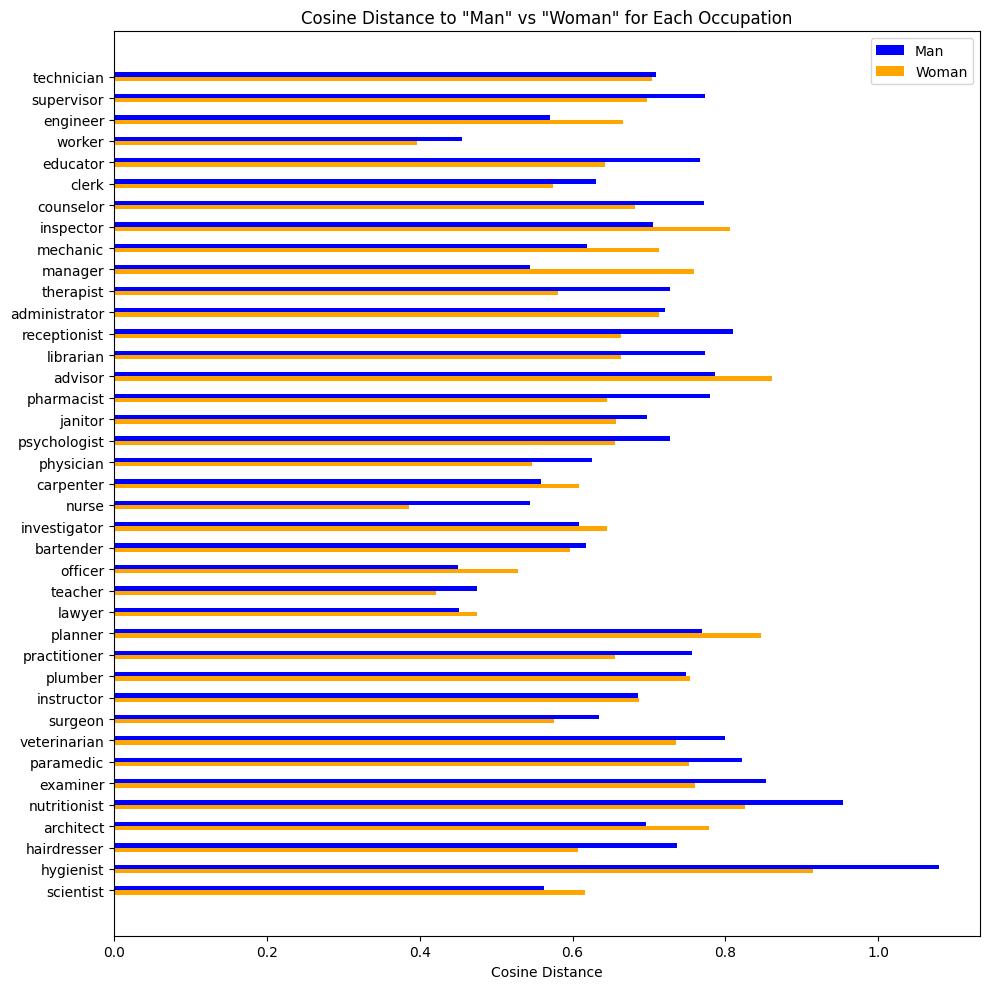

In [ ]:
# get the plot for cosine distance

occupation_names = []
man_distances = []
woman_distances = []


for occupation in occupation_list:
    if occupation in word_index:
        occupation_embedding = embedding_matrix[word_index[occupation]]
        distance_to_man = cosine(occupation_embedding, man_embedding)
        distance_to_woman = cosine(occupation_embedding, woman_embedding)

        occupation_names.append(occupation)
        man_distances.append(distance_to_man)
        woman_distances.append(distance_to_woman)


indices = np.arange(len(occupation_names))

plt.figure(figsize=(10, 10))
plt.barh(indices - 0.1, man_distances, height=0.2, color='blue', label='Man')
plt.barh(indices + 0.1, woman_distances, height=0.2, color='orange', label='Woman')
plt.yticks(indices, occupation_names)
plt.xlabel('Cosine Distance')
plt.title('Cosine Distance to "Man" vs "Woman" for Each Occupation')
plt.legend()

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Do you see a pattern in the results? Do you think there are biases?

*answer here*

**Yes, there are biases.**

The occupations' cosine distance closer to 'man' are like engineer, lawyer, scientist, manager, architect. The occupations closer to 'woman' include nurse, hygienist, librarian, educator, etc. These occupations have traditionally and historically been dominated by more men or women, but are not reflective of the current situation, as there is a growing diversification in all professions.

GloVe embeddings reflect biases because they were learned and trained on text data from the web, which are biased. This is a significant concern, as it's crucial that AI not perpetuate these stereotypes. Recognizing and addressing these biases is essential to prevent them from being ingrained in AI applications, ensuring a fair and unbiased use of AI technology.

### Q6: Sequence to Sequence Embedding

What is the problem with LSTM models, and why do we need **attention** to fix them? Give as an example of what happens with sequence to sequence models for translation.

*answer here*

**What is the problem with LSTM models?**

LSTM models have an inherent limitation due to the context vector. All information about an input sequence is compressed into a single state of memory, which is the only information passed to the decoder. This requires the networks within each recurrent cell to work very hard to compress all necessary information into the limited available space. The seq2seq architecture tends to ignores all of the encoder’s hidden states except the last. In the case of a long input, those intermediate hidden states can hold information that gets forgotten by the time we reached the end of the sentence, also known as the long-term dependency problem.

Another key problem is that an RNN must be trained and used one word at a time. This can be a slow way to work, particularly with large datasets.

**Why do we need attention to fix them?**

When we’re translating a particular word, not every word in the sentence is equally important, or even relevant at all. Attention mechanism allows the model to selectively focus on certain parts of the input sequence while ignoring others. Besides, attention mechanisms do not rely on processing words serially, we can even do it in parallel.

**Example of sequence to sequence models for translation.**

RNN dominated Seq2seq learning before being overtaken by Transformer.

When using **LSTM/GRU-based seq2seq model**, it might struggle to remember the beginning of a sentence when it reaches the end, particularly if the sentence structure in another language requires information from the start of the English sentence for correct pronoun or tense usage.

For example, in translating the sentence "The table has four sturdy legs," a reasonable memory capacity can retain enough information about the subject, a table. However, for a more complex sentence like "The table, despite all the long-distance moves, the books dropped onto it, the kids running full-speed into it, serving variously as a fort, a stepladder, and a door-stop, still has four sturdy legs," the hidden state of the model would need to be significantly larger to remember all the details. It may forget the early part of the sentence, such as the word "table."

Seq2seq learning is the task where **Transformer** really shines. Transformer encoder uses self-attention to produce context-aware representations of each token in an input sequence. The Transformer encoder reads the source sequence and produces an encoded representation - a sequence of context-aware embedding vectors of it. The Transformer decoder uses neural attention to identify which tokens in the encoded source sentence are most closely related to the target token it’s currently trying to predict. This model can "look back" at the entire input sentence and focus on the relevant parts when translating each word or phrase. This results in more accurate and contextually coherent translations.



